In [63]:
import cv2 
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal
import time
from math import sqrt
from skimage import transform
import skimage 

In [129]:
# functions 

circle = lambda r: np.array([[1 if sqrt((i-r)**2 + (j-r)**2) <= r else 0 for j in range(0, 2*r+1)] for i in range(0, 2*r+1)])

def absolute(x, y):
    return(math.sqrt(x**2 + y**2))
vect_absolute = np.vectorize(absolute)

def power(input):
    return input**2
vect_power = np.vectorize(power)

def normalizeNPA(img):
    w, h = img.shape
    denominator = np.ones((w, h)) * np.amax(img)
    return img/denominator

def get_rescaled(img, percent):
    width, height = img.shape
    resized = skimage.transform.resize(img, output_shape=[int(width * percent), 
                int(height * percent)], order=1, mode='constant', cval=0, clip=True, preserve_range=False)
    return resized

def crop_img(img, radius):
    width, height = img.shape
    return img[radius:width - radius, radius:height - radius]

def cutgreylevels(img, begin_p, end_p):
    maxval = img.max()
    diff_mapp = np.logical_and(maxval * begin_p < img, img < maxval * end_p)
    cut = diff_mapp * img
    output = np.divide(cut - cut.min(), cut.max())
    return output

def calc_dist(histogram, x, y):
    base = histogram[x][y]
    rep_base = np.tile(base,(3, 1))
    extended_base = np.ndarray((3, 3, 10))
    extended_base[:] = rep_base
    dist = (extended_base - histogram[x-1:x+2, y-1:y+2])
    dist = np.power(dist, 2)
    dist = np.sum(dist, axis=2)
    dist = np.sqrt(dist)
    dist = np.sum(np.sum(dist))
    return dist

def get_scale(magnitude_angle, angle):
    # returns the ammount the magnitude should be scaled in 
    # reference to given angle only count positive values     
    output = abs((1 - np.absolute(np.divide(magnitude_angle - angle, math.pi/2))))
    return output

def get_mapp(magnitude_angle, angle):
    # -pi <= angle <= pi 
    # determines if the magnitude_angle is pointing in the same direction as the 
    mapp_angles = np.logical_and(magnitude_angle <= math.pi/2 + angle, magnitude_angle >= -math.pi/2 + angle)
    return mapp_angles

def normalizeStd1Mean0(image):
    image = image - np.mean(image)
    return image/np.std(image)

def histEq(image, number_bins=256):

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf

def inverse(img):
    return np.abs(img - 1)

def threshold(img):
    thresh = np.mean(img)
    img[img > thresh] = 1
    img[img <= thresh] = 0
    return img

In [130]:
# M1 
# The variance of the greylevel histogram over a circular neighbourhood
# of radius 3 (total area N = 29 pixels) at each pixel is used as a measure of how much local information there is:

def calc_M1(img):
    width, height = img.shape
    bins = 10
    histogram = np.ndarray((width, height, bins))
    hist_variance = np.zeros((width, height))
    radius = 3
    kernel = circle(radius)
    denominator = kernel.sum()
    img_force_int = img.astype('float')
    for x in range(radius, width-radius):
        for y in range(radius, height-radius):
            crop = img_force_int[x - radius:x + radius + 1, y - radius:y + radius + 1]
            croped_crop = crop[kernel == 1]
            hist, trash = np.histogram(np.hstack(croped_crop),bins)
            histogram[x][y] = hist
            var = np.nanvar(histogram[x][y])
            hist_variance[x][y] = var
    
#     histogram_croped = histogram[radius:width - radius, radius:height - radius]
#     hist_variance_croped = hist_variance[radius:width - radius, radius:height - radius]    
    M1 = hist_variance
    return M1, histogram

# M2
# Text regions have a high density of edges. This density is measured in a circular neighbourhood of 
# radius 6 centred at each pixel by summing all edge magnitudes located with a Sobel filter:

def calc_M2(img):
    Gx_kernel = np.matrix([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy_kernel = np.matrix([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    Gx = signal.convolve2d(img, Gx_kernel, 'same')
    Gy = signal.convolve2d(img, Gy_kernel, 'same')
    G = vect_absolute(Gx, Gy)
    G = G.astype(np.uint8)
    # sum all edge magnitudes 
    kernel = circle(6)
    M2 = signal.convolve2d(G, kernel, 'same')
    
    return M2

# M3
# the ratio of text to non-text intensity greylevels should not vary greatly as we pass over a text region.
# hypothesise that there will be only a small change in local greylevel histograms across a text region.

def calc_M3(histogramFromM1):
    width, height, bins = histogramFromM1.shape
    M3 = np.zeros((width, height))
    for x in range(1, width-2):
        for y in range(1, height-2):
            dist = calc_dist(histogramFromM1, x, y)
            M3[x][y] = dist

    return M3

# M4
# In high resolution images one expects to find a high number of edges in a text region, and 
# the angles of the edges to be well distributed due to the presence of curves on many characters. 
# However, this will not be the case at low resolution, where individual characters merge and edges follow
# the tops and bottoms of text lines.

# Different take on the filter, only use angle not magnitude. 

def calc_M4(img):
    
    width, height = img.shape
    angle = 0
    radius = 6
    bins = 8
    kernel = circle(radius)
    
    # calculate magnitude vector
    Gx_kernel = np.matrix([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy_kernel = np.matrix([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    Gx = signal.convolve2d(img, Gx_kernel, 'same')
    Gy = signal.convolve2d(img, Gy_kernel, 'same')
    Gvector = np.ndarray([2, width, height])
    Gvector[0, ...] = Gx
    Gvector[1, ...] = Gy
    magnitude = vect_absolute(Gx, Gy)
    # calculate angles of magnitude
    magnitude_angle = np.arctan2(Gx, Gy)

    histograms = np.ndarray((width, height, 2, bins))
    M4 = np.ndarray((width, height))
    # print(crop.size)
    for x in range(radius, width - radius):
        for y in range(radius, height - radius):
            crop = magnitude_angle[(x - radius):(x + radius + 1), (y - radius):(y + radius + 1)]
            cropped_with_kernel = crop[kernel == 1]
            cropped_with_kernel = cropped_with_kernel.reshape(cropped_with_kernel.size, 1)
            # mapp instances of 0 < x <= pi to 1 and pi < x <= 2pi to 0           
            mapp = np.logical_and(0 < cropped_with_kernel, cropped_with_kernel <= math.pi)
            # crop_1 is the angles from 0  to  pi
            # crop_2 is the angles from pi to 2pi     
            crop_1 = cropped_with_kernel[mapp == 1]
            crop_2 = cropped_with_kernel[mapp == 0]

            # when the size of either part is zero we create a "zero" histogram,
            # an array of zeros the size of the number of bins(in this case 8)
            if (crop_1.size == 0):
                histogram_1 = np.zeros(8)
                histogram_2, trash = np.histogram(np.hstack(crop_2),bins)
            elif (crop_2.size == 0):
                histogram_1, trash = np.histogram(np.hstack(crop_1),bins)
                histogram_2 = np.zeros(8)
            else: 
                histogram_1, trash = np.histogram(np.hstack(crop_1),bins)            
                histogram_2, trash = np.histogram(np.hstack(crop_2),bins)

            diff = histogram_1 - np.flipud(histogram_2)
            power = vect_power(diff)
            result = math.sqrt(sum(power))
            M4[x, y] = result
            histograms[x, y, 0] = histogram_1
            histograms[x, y, 1] = histogram_2
    
#     histograms_croped = histograms[radius:width - radius, radius:height - radius]
    
    return M4, histograms

# M5
# The first four measures respond in the same way to straight image features as to coarse or curved features. 
# This measure is employed to reject those areas of the image with tight distributions
# of edges corresponding to straight ramps, canals or ridges in the image. 
# It examines how evenly spread the edge magnitudes are over all the directions:

# use histograms calculated in M4
def calc_M5(histogramFromM4):
    bins = 8
    width, height, trash, trash = histogramFromM4.shape
    pi = math.pi
    M5 = np.ndarray((width, height))
    for x in range(0, width):
        for y in range(0, height):
            histogram_1 = histogramFromM4[x, y, 0]
            histogram_2 = histogramFromM4[x, y, 1]
            local_average = (sum(histogram_1) + sum(histogram_2))/(bins*2)
            result = 0
            for theta in range(0, 8):
                # use absolute value
    #             result += abs(local_average - histogram_1[theta])
    #             result += abs(local_average - histogram_2[theta])
                # use power of
                result += (local_average - histogram_1[theta])**2
                result += (local_average - histogram_2[theta])**2
            M5[x, y] = result

    return M5


def sizeofimg(img):
    W, H = img.shape
    print "W " + str(W) + " H " + str(H)

In [132]:
# PART I takes alot of time
start = time.time()
img = cv2.imread('./img/bok11.png', 0)
kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(img,-1,kernel)
img_rescaled = get_rescaled(dst, 0.2)

M1, histogramFromM1  = calc_M1(img_rescaled)
print str(int(time.time() - start)) + " sec" + "\n" + "finished calculating M1"

M2 = calc_M2(img_rescaled)
print str(int(time.time() - start)) + " sec" + "\n" + "finished calculating M2"

M3 = calc_M3(histogramFromM1)
print str(int(time.time() - start)) + " sec" + "\n" + "finished calculating M3"

M4, histogramFromM4 = calc_M4(img_rescaled)
print str(int(time.time() - start)) + " sec" + "\n" + "finished calculating M4"

M5 = calc_M5(histogramFromM4)
print str(int(time.time() - start)) + " sec" + "\n" + "finished calculating M5"

59 sec
finished calculating M1
60 sec
finished calculating M2
67 sec
finished calculating M3
200 sec
finished calculating M4
203 sec
finished calculating M5


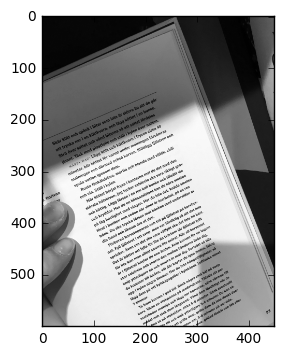

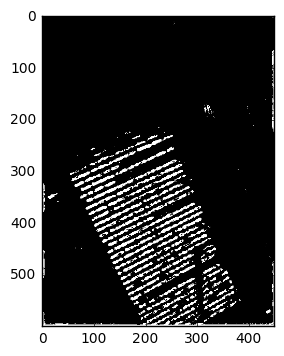

In [131]:
# PART II takes less time, copy filters as to not destroy variables
M1cp = M1
M2cp = M2
M3cp = M3
M4cp = M4
M5cp = M5

# normalize each filter to zero mean and standard deviation 1
M1norm = normalizeStd1Mean0(M1cp)
M2norm = normalizeStd1Mean0(M2cp)
M3norm = normalizeStd1Mean0(M3cp)
M4norm = normalizeStd1Mean0(M4cp)
M5norm = normalizeStd1Mean0(M5cp)

# threshhold each image with cutoff mean
M1thresh = threshold(M1norm)
M2thresh = threshold(M2norm)
M3thresh = threshold(M3norm)
M4thresh = threshold(M4norm)
M5thresh = threshold(M5norm)

# combine filters
combine = inverse(M1thresh) + M2thresh + inverse(M3thresh) + inverse(M4thresh) + inverse(M5thresh)
combine[combine < 5] = 0
combine[combine == 5] = 1

# plot result 
plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(img_rescaled, 'gray')
plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(combine, 'gray')

In [ ]:
# new idea, make a dynamic threshold of image before processing for textrecognition